# Ranges of Similar Variables

In [1]:
# NOTE: This notebook uses the polars package
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np

from plotnine import *
import polars as pl
from polars import col

*Comparing the point to point difference of many similar variables*

Read the data.

Source: Pew Research Global Attitudes Spring 2015

In [2]:
!head -n 20 'data/survey-social-media.csv'

PSRAID,COUNTRY,Q145,Q146,Q70,Q74
100000,Ethiopia,Female,35,No, 
100001,Ethiopia,Female,25,No, 
100002,Ethiopia,Male,40,Don’t know, 
100003,Ethiopia,Female,30,Don’t know, 
100004,Ethiopia,Male,22,No, 
100005,Ethiopia,Male,40,No, 
100006,Ethiopia,Female,20,No, 
100007,Ethiopia,Female,18,No,No
100008,Ethiopia,Male,50,No, 
100009,Ethiopia,Male,35,No, 
100010,Ethiopia,Female,20,No, 
100011,Ethiopia,Female,30,Don’t know, 
100012,Ethiopia,Male,60,No, 
100013,Ethiopia,Male,18,No, 
100014,Ethiopia,Male,40,No, 
100015,Ethiopia,Male,28,Don’t know, 
100016,Ethiopia,Female,55,Don’t know, 
100017,Ethiopia,Male,30,Don’t know, 
100018,Ethiopia,Female,22,No, 

In [3]:
columns = dict(
    COUNTRY='country',
    Q145='gender',
    Q146='age',
    Q70='use_internet',
    Q74='use_social_media'
)

data = pl.scan_csv(
    'data/survey-social-media.csv',
    dtypes=dict(Q146=pl.Utf8),
).rename(
    columns
).select([
    'country',
    'age',
    'use_social_media'
]).collect()

data.sample(10, seed=123)

country,age,use_social_media
str,str,str
"""Venezuela""","""47""","""Yes"""
"""Israel""","""63""",""" """
"""Germany""","""60""","""Yes"""
"""France""","""60""","""No"""
"""Philippines""","""25""",""" """
"""China""","""40""",""" """
"""Senegal""","""20""",""" """
"""Argentina""","""47""","""Yes"""
"""India""","""53""","""No"""


Create age groups for users of social media

In [4]:
yes_no = ['Yes', 'No']
valid_age_groups = ['18-34', '35-49', '50+']

rdata = data.with_columns([
    pl
    .when(col('age') <= '34').then('18-34')
    .when(col('age') <= '49').then('35-49')
    .when(col('age') < '98').then('50+')
    .otherwise("")
    .alias('age_group'),
    pl.count().over("country").alias('country_count')
]).filter(
    col('age_group').is_in(valid_age_groups) &
    col('use_social_media').is_in(yes_no)
).groupby(['country', 'age_group']).agg([
    # social media use percentage
    ((col('use_social_media') == 'Yes').sum() * 100 / pl.count()).alias('sm_use_percent'),
    
    # social media question response rate
    (col('use_social_media').is_in(yes_no).sum() * 100 / col('country_count').first()).alias('smq_response_rate')
]).sort(['country', 'age_group'])

rdata.head()

country,age_group,sm_use_percent,smq_response_rate
str,str,f64,f64
"""Argentina""","""18-34""",90.883191,35.1
"""Argentina""","""35-49""",84.40367,21.8
"""Argentina""","""50+""",67.333333,15.0
"""Australia""","""18-34""",90.862944,19.621514
"""Australia""","""35-49""",78.04878,20.418327


Top 14 countries by response rate to the social media question.

In [5]:
def col_format(name, fmt):
    # Format useing python formating
    # for more control over
    return col(name).apply(lambda x: fmt.format(x=x))

def float_to_str_round(name):
    return col_format(name, '{x:.0f}')

n = 14

top = rdata.groupby('country').agg([
    col('smq_response_rate').sum().alias('r')
]).sort('r', reverse=True).head(n)
top_countries = top['country']

expr = float_to_str_round('sm_use_percent')
expr_pct = expr + '%'

point_data = rdata.filter(
    col('country').is_in(top_countries)
).with_column(
    pl.when(col('country') == 'France').then(expr_pct).otherwise(expr).alias('sm_use_percent_str')
)

point_data.head()

country,age_group,sm_use_percent,smq_response_rate,sm_use_percent_str
str,str,f64,f64,str
"""Australia""","""18-34""",90.862944,19.621514,"""91"""
"""Australia""","""35-49""",78.04878,20.418327,"""78"""
"""Australia""","""50+""",48.479087,52.390438,"""48"""
"""Canada""","""18-34""",92.063492,25.099602,"""92"""
"""Canada""","""35-49""",75.925926,21.513944,"""76"""


In [6]:
segment_data = point_data.groupby('country').agg([
    col('sm_use_percent').min().alias('min'),
    col('sm_use_percent').max().alias('max'),
]).with_column(
    (col('max') - col('min')).alias('gap')
).sort(
    'gap',
).with_columns([
    float_to_str_round('min').alias('min_str'),
    float_to_str_round('max').alias('max_str'),
    float_to_str_round('gap').alias('gap_str')
])

segment_data.head()

country,min,max,gap,min_str,max_str,gap_str
str,f64,f64,f64,str,str,str
"""Russia""",76.07362,95.151515,19.077896,"""76""","""95""","""19"""
"""Israel""",55.405405,88.311688,32.906283,"""55""","""88""","""33"""
"""United Kingdom...",52.74463,86.096257,33.351627,"""53""","""86""","""33"""
"""United States""",52.597403,88.669951,36.072548,"""53""","""89""","""36"""
"""Canada""",53.986333,92.063492,38.077159,"""54""","""92""","""38"""


Format the floating point data that will be plotted into strings

Set the order of the countries along the y-axis by setting the `country`
variable to an ordered categorical.

In [7]:
country_expr = col('country').cast(pl.Categorical)
segment_data = segment_data.with_column(country_expr)
point_data = point_data.with_columns(country_expr)

First plot

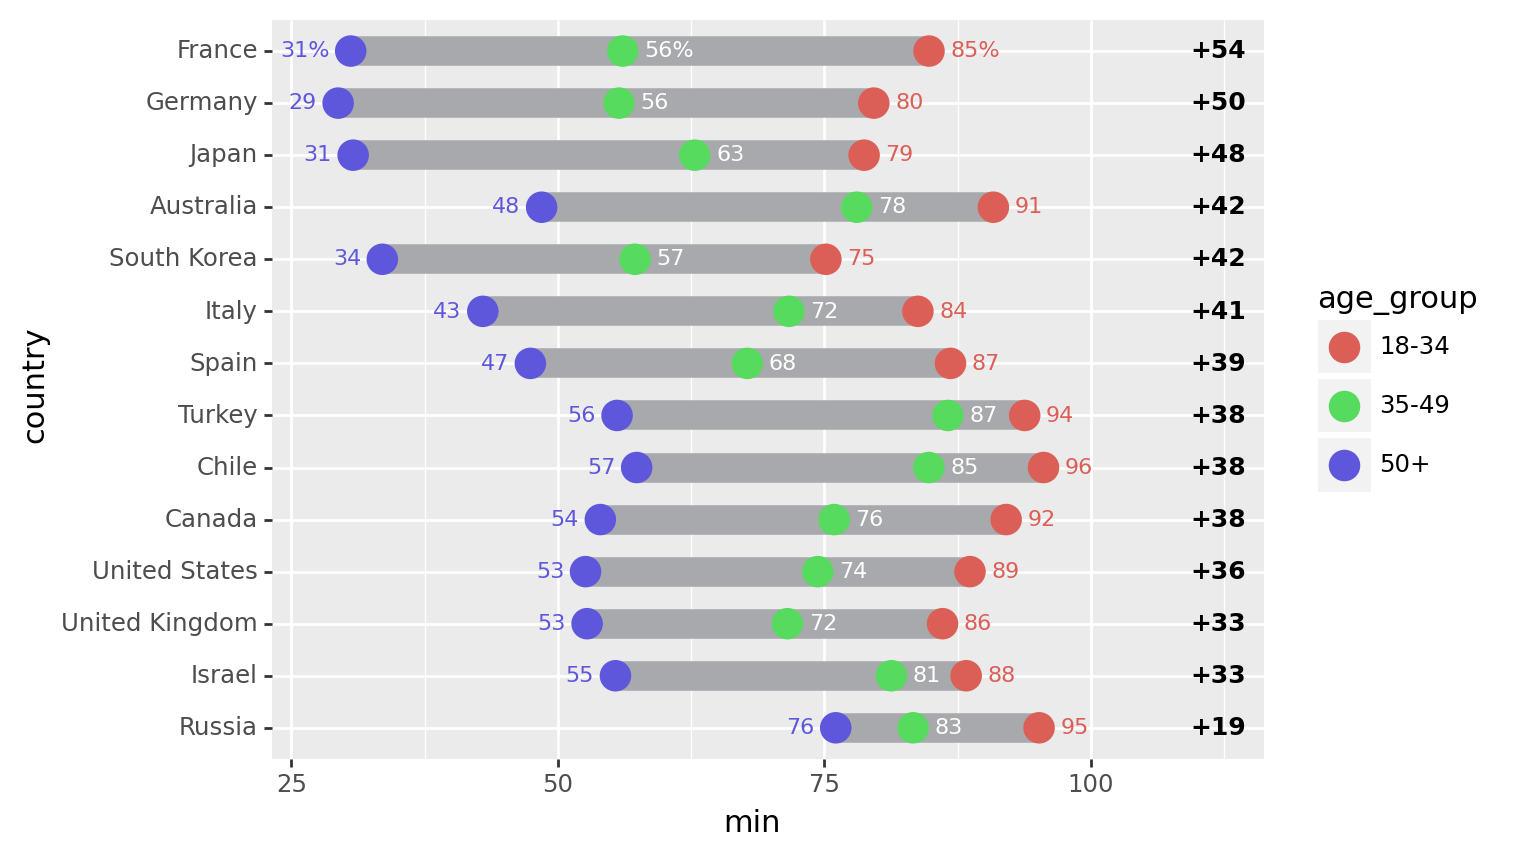

In [8]:
# The right column (youngest-oldest gap) location
xgap = 112

(ggplot()
 # Range strip
 + geom_segment(
     segment_data,
     aes(x='min', xend='max', y='country', yend='country'),
     size=6,
     color='#a7a9ac'
 )
 # Age group markers
 + geom_point(
     point_data,
     aes('sm_use_percent', 'country', color='age_group', fill='age_group'),
     size=5,
     stroke=0.7,
 )
 # Age group percentages
 + geom_text(
     point_data.filter(col('age_group')=="50+"),
     aes(x='sm_use_percent-2', y='country', label='sm_use_percent_str', color='age_group'),
     size=8,
     ha='right'
 )
 + geom_text(
     point_data.filter(col('age_group')=="35-49"),
     aes(x='sm_use_percent+2', y='country', label='sm_use_percent_str'),
     size=8,
     ha='left',
     va='center',
     color='white'
 )
 + geom_text(
     point_data.filter(col('age_group')=="18-34"),
     aes(x='sm_use_percent+2', y='country', label='sm_use_percent_str', color='age_group'),
     size=8,
     ha='left',
 )
 # gap difference
 + geom_text(
     segment_data,
     aes(x=xgap, y='country', label='gap_str'),
     size=9,
     fontweight='bold',
     format_string='+{}'
 )
)

Tweak it

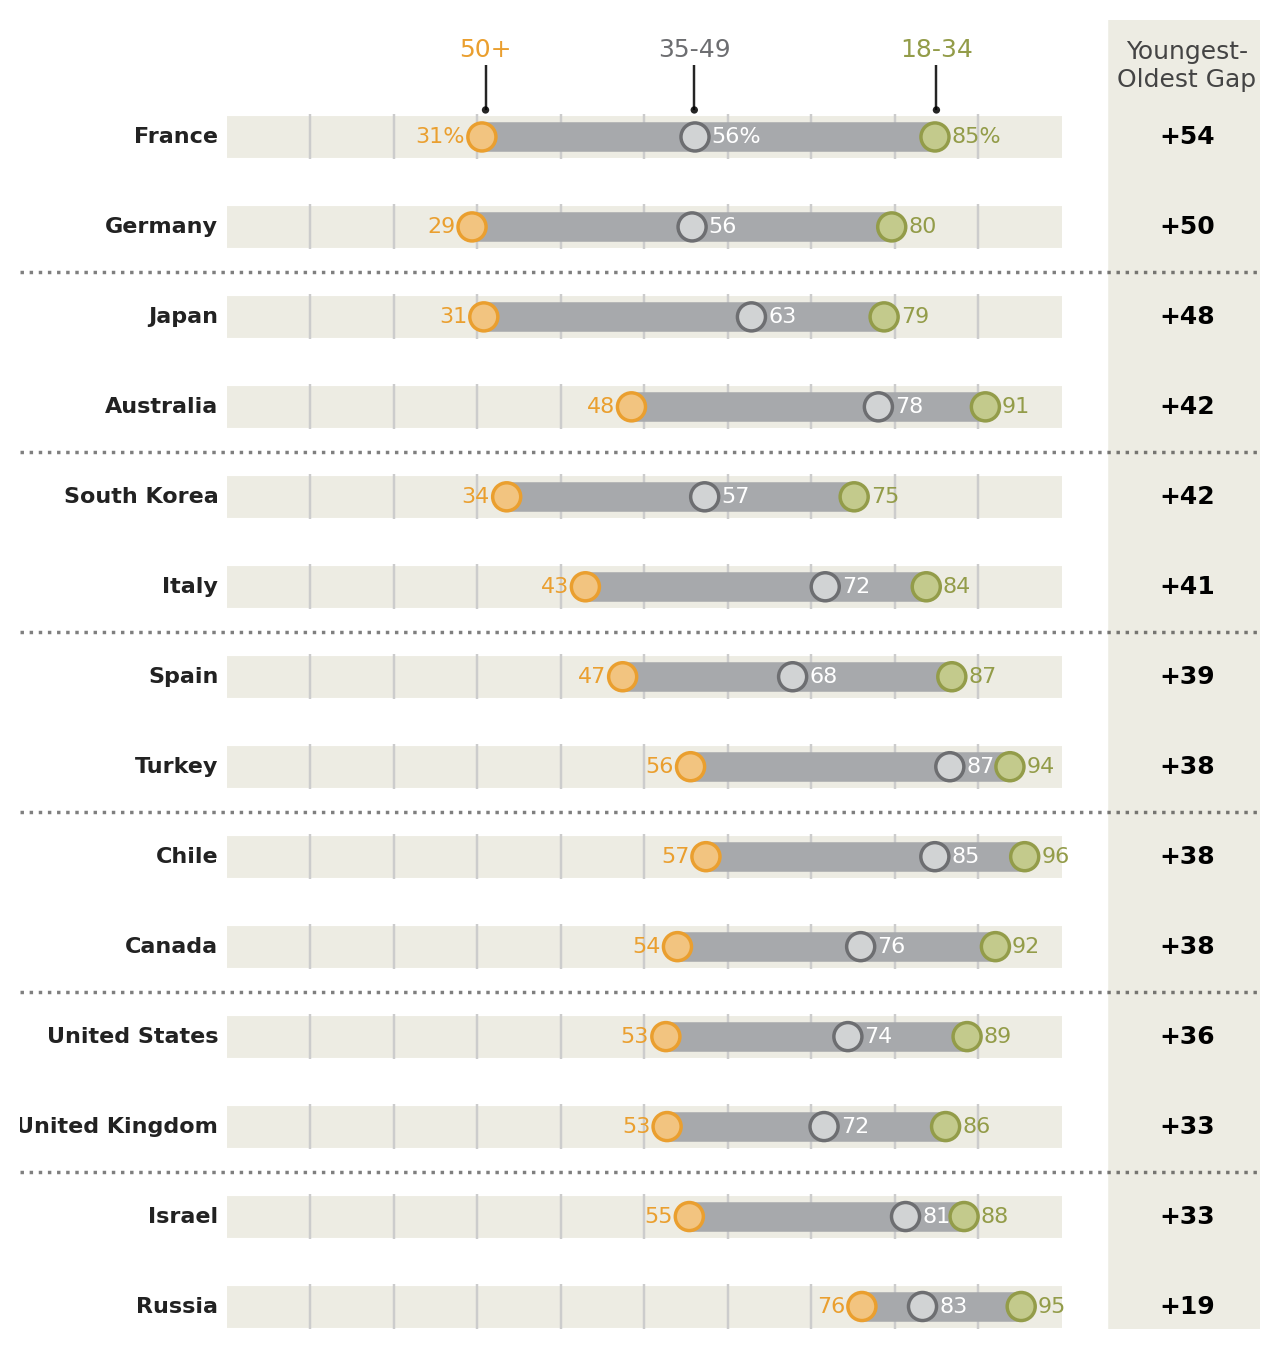

In [9]:
# The right column (youngest-oldest gap) location
xgap = 115

# Gallery Plot

(ggplot()
 # Background Strips                                     # new
 + geom_segment(
     segment_data,
     aes(y='country', yend='country'),
     x=0, xend=100,
     size=8.5,
     color='#edece3'
 )
 # vertical grid lines along the strips                  # new
 + annotate(
     'segment',
     x=list(range(10, 100, 10)) * n,
     xend=list(range(10, 100, 10)) * n,
     y=np.tile(np.arange(1, n+1), 9)-.25,
     yend=np.tile(np.arange(1, n+1), 9) + .25,
     color='#CCCCCC'
 )
 # Range strip
 + geom_segment(
     segment_data,
     aes(x='min', xend='max', y='country', yend='country'),
     size=6,
     color='#a7a9ac'
 )
 # Age group markers
 + geom_point(
     point_data,
     aes('sm_use_percent', 'country', color='age_group', fill='age_group'),
     size=5,
     stroke=0.7,
 )
 # Age group percentages
 + geom_text(
     point_data.filter(col('age_group')=="50+"),
     aes(x='sm_use_percent-2', y='country', label='sm_use_percent_str', color='age_group'),
     size=8,
     ha='right',
 )
 + geom_text(
     point_data.filter(col('age_group')=="35-49"),
     aes(x='sm_use_percent+2', y='country', label='sm_use_percent_str'),
     size=8,
     ha='left',
     va='center',
     color='white'
 )
 + geom_text(
     point_data.filter(col('age_group')=="18-34"),
     aes(x='sm_use_percent+2', y='country', label='sm_use_percent_str', color='age_group'),
     size=8,
     ha='left',
 )
 # countries right-hand-size (instead of y-axis)         # new
 + geom_text(
     segment_data,
     aes(y='country', label='country'),
     x=-1,
     size=8,
     ha='right',
     fontweight='bold',
     color='#222222'
 )
 # gap difference
 + geom_vline(xintercept=xgap, color='#edece3', size=32)  # new
 + geom_text(
     segment_data,
     aes(x=xgap, y='country', label='gap_str'),
     size=9,
     fontweight='bold',
     format_string='+{}'
 )
 # Annotations                                            # new
 + annotate('text', x=31, y=n+1.1, label='50+', size=9, color='#ea9f2f', va='top')
 + annotate('text', x=56, y=n+1.1, label='35-49', size=9, color='#6d6e71', va='top')
 + annotate('text', x=85, y=n+1.1, label='18-34', size=9, color='#939c49', va='top')
 + annotate('text', x=xgap, y=n+.5, label='Youngest-\nOldest Gap', size=9, color='#444444', va='bottom', ha='center')
 + annotate('point', x=[31, 56, 85], y=n+.3, alpha=0.85, stroke=0)
 + annotate('segment', x=[31, 56, 85], xend=[31, 56, 85], y=n+.3, yend=n+.8, alpha=0.85)
 + annotate('hline', yintercept=[x+0.5 for x in range(2, n, 2)], alpha=.5, linetype='dotted', size=0.7)
 
 # Better spacing and color                              # new
 + scale_x_continuous(limits=(-18, xgap+2))
 + scale_y_discrete(expand=(0, 0.25, 0.1, 0))
 + scale_fill_manual(values=['#c3ca8c', '#d1d3d4', '#f2c480'])
 + scale_color_manual(values=['#939c49', '#6d6e71', '#ea9f2f'])
 + guides(color=None, fill=None)
 + theme_void()
 + theme(figure_size=(8, 8.5))
)

Instead of looking at this plot as having a country variable on the
`y-axis` and a percentage variable on the `x-axis`, we can view it as
having vertically stacked up many *indepedent* variables, the values of
which have a similar scale.

**Protip:** Save a pdf file.

### Change in Rank

*Comparing a group of ranked items at two different times*

Read the data.

Source: World Bank - Infanct Mortality Rate (per 1,000 live births)b

In [10]:
data = pl.read_csv(
    'data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv',
    skip_rows=4,
    null_values="",
)

# Columns as valid python variables
year_columns = {c: f'y{c}' for c in data.columns if c[:2] in {'19', '20'}}
data = data.rename({
    'Country Name': 'country',
    'Country Code': 'code',
    **year_columns
}).drop(['Indicator Name', 'Indicator Code'])
data.head()

country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,y1968,y1969,y1970,y1971,y1972,y1973,y1974,y1975,y1976,y1977,y1978,y1979,y1980,y1981,y1982,y1983,y1984,y1985,y1986,y1987,y1988,y1989,y1990,y1991,y1992,y1993,y1994,y1995,y1996,y1997,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""Aruba""","""ABW""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Afghanistan""","""AFG""",null,240.5,236.3,232.3,228.5,224.6,220.7,217.0,213.3,209.8,206.1,202.2,198.2,194.3,190.3,186.6,182.6,178.7,174.5,170.4,166.1,161.8,157.5,153.2,148.7,144.5,140.2,135.7,131.3,126.8,122.5,118.3,114.4,110.9,107.7,105.0,102.7,100.7,98.9,97.2,95.4,93.4,91.2,89.0,86.7,84.4,82.3,80.4,78.6,76.8,75.1,73.4,71.7,69.9,68.1,66.3,null
"""Angola""","""AGO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,138.3,137.5,136.8,136.0,135.3,134.9,134.4,134.1,133.8,133.6,133.5,133.5,133.5,133.4,133.2,132.8,132.3,131.5,130.6,129.5,128.3,126.9,125.5,124.1,122.8,121.2,119.4,117.1,114.7,112.2,109.6,106.8,104.1,101.4,98.8,96.0,null
"""Albania""","""ALB""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,73.0,68.4,64.0,59.9,56.1,52.4,49.1,45.9,43.2,40.8,38.6,36.7,35.1,33.7,32.5,31.4,30.3,29.1,27.9,26.8,25.5,24.4,23.2,22.1,21.0,20.0,19.1,18.3,17.4,16.7,16.0,15.4,14.8,14.3,13.8,13.3,12.9,12.5,null
"""Andorra""","""AND""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.5,7.0,6.5,6.1,5.6,5.2,5.0,4.6,4.3,4.1,3.9,3.7,3.5,3.3,3.2,3.1,2.9,2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.1,null


The data includes regional aggregates. To tell apart the regional
aggregates we need the metadata. Every row in the data table has a
corresponding row in the metadata table. Where the row has regional
aggregate data, the `Region` column in the metadata table is `NaN`.

In [11]:
def ordered_categorical(s, categories=None):
    """
    Create a categorical ordered according to the categories
    """
    name = getattr(s, 'name', '')
    if categories is None:
        return pl.Series(name, s).cast(pl.Categorical)

    with pl.StringCache():
        pl.Series(categories).cast(pl.Categorical)
        return pl.Series(name, s).cast(pl.Categorical)

columns = {
    'Country Code': 'code',
    'Region': 'region',
    'IncomeGroup': 'income_group'
}

metadata = pl.scan_csv(
    'data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/Metadata_Country_API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv'
).rename(
    columns
).select(
    list(columns.values())
).filter(
    # Drop the regional aggregate information
    (col('region') != '') & (col('income_group') != '')
).collect()

cat_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
metadata = metadata.with_columns([
    ordered_categorical(metadata['income_group'], cat_order)
])

metadata.head(10)

code,region,income_group
str,str,cat
"""ABW""","""Latin America ...","""High income"""
"""AFG""","""South Asia""","""Low income"""
"""AGO""","""Sub-Saharan Af...","""Lower middle i..."
"""ALB""","""Europe & Centr...","""Upper middle i..."
"""AND""","""Europe & Centr...","""High income"""
"""ARE""","""Middle East & ...","""High income"""
"""ARG""","""Latin America ...","""Upper middle i..."
"""ARM""","""Europe & Centr...","""Lower middle i..."
"""ASM""","""East Asia & Pa...","""Upper middle i..."


Remove the regional aggregates, to create a table with only country data

In [12]:
country_data = data.join(metadata, on='code')
country_data.head()

country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,y1968,y1969,y1970,y1971,y1972,y1973,y1974,y1975,y1976,y1977,y1978,y1979,y1980,y1981,y1982,y1983,y1984,y1985,y1986,y1987,y1988,y1989,y1990,y1991,y1992,y1993,y1994,y1995,y1996,y1997,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,region,income_group
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,cat
"""Aruba""","""ABW""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Latin America ...","""High income"""
"""Afghanistan""","""AFG""",null,240.5,236.3,232.3,228.5,224.6,220.7,217.0,213.3,209.8,206.1,202.2,198.2,194.3,190.3,186.6,182.6,178.7,174.5,170.4,166.1,161.8,157.5,153.2,148.7,144.5,140.2,135.7,131.3,126.8,122.5,118.3,114.4,110.9,107.7,105.0,102.7,100.7,98.9,97.2,95.4,93.4,91.2,89.0,86.7,84.4,82.3,80.4,78.6,76.8,75.1,73.4,71.7,69.9,68.1,66.3,null,"""South Asia""","""Low income"""
"""Angola""","""AGO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,138.3,137.5,136.8,136.0,135.3,134.9,134.4,134.1,133.8,133.6,133.5,133.5,133.5,133.4,133.2,132.8,132.3,131.5,130.6,129.5,128.3,126.9,125.5,124.1,122.8,121.2,119.4,117.1,114.7,112.2,109.6,106.8,104.1,101.4,98.8,96.0,null,"""Sub-Saharan Af...","""Lower middle i..."
"""Albania""","""ALB""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,73.0,68.4,64.0,59.9,56.1,52.4,49.1,45.9,43.2,40.8,38.6,36.7,35.1,33.7,32.5,31.4,30.3,29.1,27.9,26.8,25.5,24.4,23.2,22.1,21.0,20.0,19.1,18.3,17.4,16.7,16.0,15.4,14.8,14.3,13.8,13.3,12.9,12.5,null,"""Europe & Centr...","""Upper middle i..."
"""Andorra""","""AND""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.5,7.0,6.5,6.1,5.6,5.2,5.0,4.6,4.3,4.1,3.9,3.7,3.5,3.3,3.2,3.1,2.9,2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.1,null,"""Europe & Centr...","""High income"""


We are interested in the changes in rank between 1960 and 2015. To plot
a reasonable sized graph, we randomly sample 35 countries.

In [13]:
sampled_data = country_data.drop_nulls(
    subset=['y1960', 'y2015']
).sample(
    n=35,
    seed=123
).with_columns([
    col('y1960').rank(method='ordinal').cast(pl.Int64).suffix('_rank'),
    col('y2015').rank(method='ordinal').cast(pl.Int64).suffix('_rank')
]).sort('y2015_rank', reverse=True)

sampled_data.head()

country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,y1968,y1969,y1970,y1971,y1972,y1973,y1974,y1975,y1976,y1977,y1978,y1979,y1980,y1981,y1982,y1983,y1984,y1985,y1986,y1987,y1988,y1989,y1990,y1991,y1992,y1993,y1994,y1995,y1996,y1997,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,region,income_group,y1960_rank,y2015_rank
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,cat,i64,i64
"""Togo""","""TGO""",162.4,159.4,156.4,153.5,150.5,147.7,144.7,141.8,138.8,135.8,132.8,130.0,127.2,124.4,121.8,119.2,116.6,114.1,111.7,109.2,106.9,104.8,102.7,100.7,98.9,97.1,95.5,94.0,92.6,91.4,90.2,89.0,87.9,86.8,85.5,84.2,82.8,81.2,79.6,77.9,76.2,74.4,72.6,70.8,69.1,67.4,65.7,64.1,62.5,60.9,59.3,57.9,56.5,55.0,53.6,52.3,null,"""Sub-Saharan Af...","""Low income""",33,35
"""Haiti""","""HTI""",194.8,191.5,188.3,185.2,182.2,179.1,176.0,172.9,169.8,166.6,163.4,160.1,156.6,153.0,149.5,146.0,142.6,139.2,135.8,132.5,129.4,126.2,123.0,120.0,117.1,114.3,111.5,108.8,106.1,103.5,101.0,98.4,95.8,93.1,90.4,87.8,85.1,82.4,79.9,77.4,75.0,72.8,70.7,68.9,67.2,65.6,64.1,62.7,61.3,60.0,85.5,57.5,56.2,54.8,53.5,52.2,null,"""Latin America ...","""Low income""",35,34
"""Gambia, The""","""GMB""",148.4,146.1,143.8,141.5,139.3,137.1,134.9,132.6,130.5,128.3,126.0,123.8,121.5,119.1,116.7,114.4,112.1,109.8,107.6,105.4,103.2,100.9,98.6,96.2,93.7,91.3,88.9,86.5,84.3,82.1,80.0,78.0,76.1,74.3,72.6,70.9,69.3,67.7,66.2,64.8,63.3,62.0,60.6,59.3,58.0,56.8,55.6,54.5,53.6,52.6,51.7,50.9,50.1,49.4,48.6,47.9,null,"""Sub-Saharan Af...","""Low income""",32,33
"""Zimbabwe""","""ZWE""",92.6,90.1,87.6,85.3,82.8,80.5,78.3,76.3,74.7,73.4,72.4,71.6,71.1,70.7,70.5,70.3,70.1,69.8,69.2,68.1,66.4,64.2,61.6,58.8,56.0,53.6,51.7,50.4,49.8,50.2,51.2,52.6,54.5,56.4,58.1,60.1,61.6,62.7,63.3,63.5,63.5,63.2,62.7,61.9,61.5,61.0,60.3,59.9,58.9,57.7,55.8,54.0,49.4,48.8,47.6,46.6,null,"""Sub-Saharan Af...","""Low income""",19,32
"""Zambia""","""ZMB""",123.2,120.9,118.7,116.7,115.1,114.0,113.3,112.9,112.2,111.1,109.3,106.7,103.7,100.7,98.1,96.3,95.3,95.1,95.3,95.6,96.1,97.0,98.3,100.2,102.7,105.6,108.3,110.6,112.2,113.1,113.3,113.0,112.4,111.3,109.7,107.8,106.1,104.6,103.1,100.9,97.6,92.7,86.5,80.0,73.9,68.7,64.9,61.3,58.7,55.6,52.9,51.1,49.0,46.5,44.7,43.3,null,"""Sub-Saharan Af...","""Lower middle i...",23,31


First graph

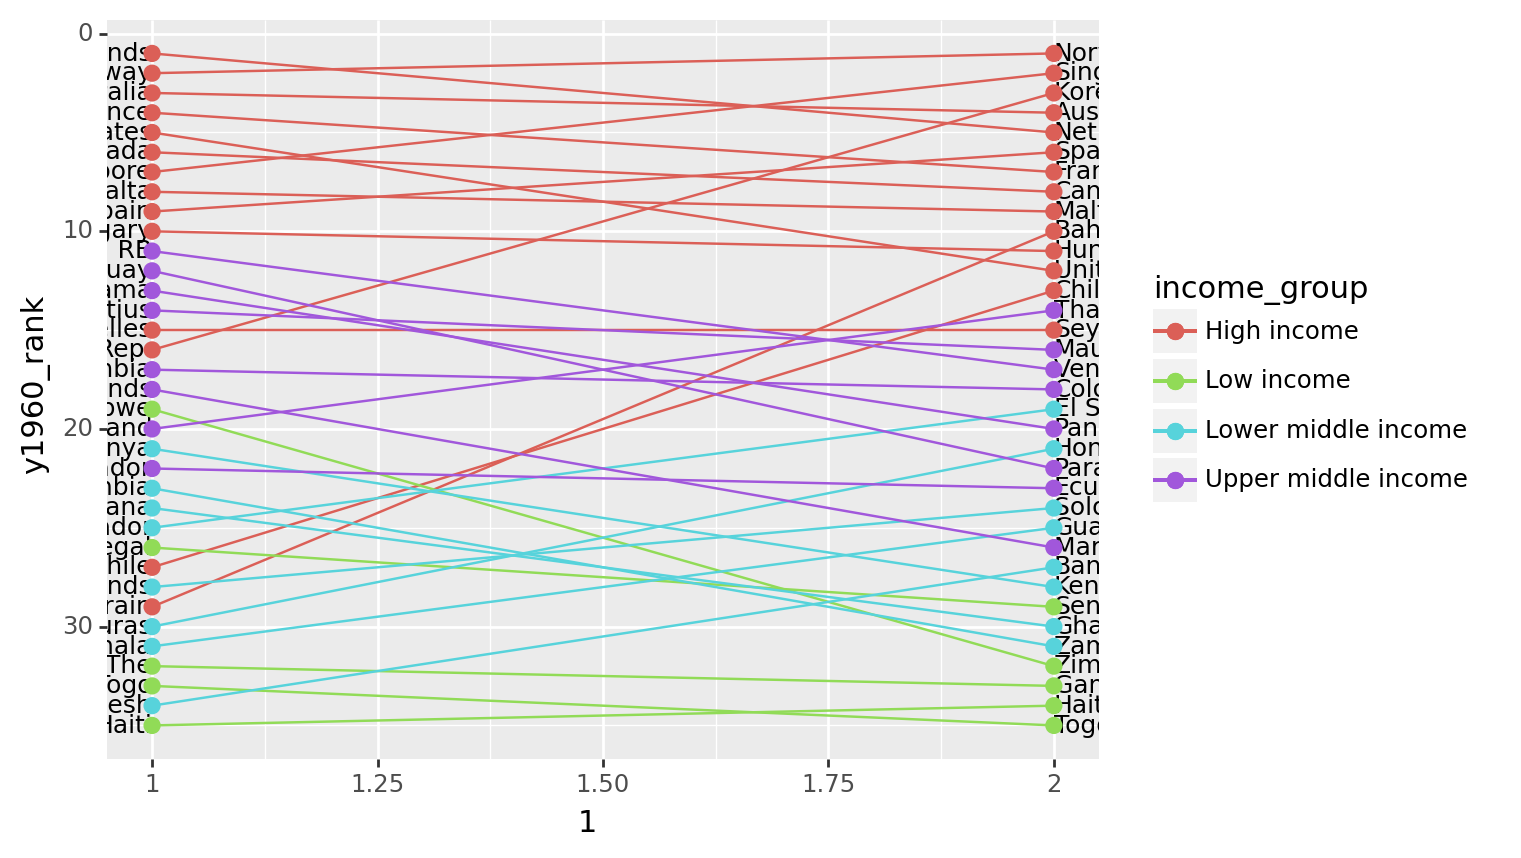

In [14]:
(ggplot(sampled_data)
 + geom_text(aes(1, 'y1960_rank', label='country'), ha='right', size=9)
 + geom_text(aes(2, 'y2015_rank', label='country'), ha='left', size=9)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5)
 + geom_point(aes(2, 'y2015_rank', color='income_group'), size=2.5)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2015_rank', color='income_group'))
 + scale_y_reverse()
)

It has the form we want, but we need to tweak it.

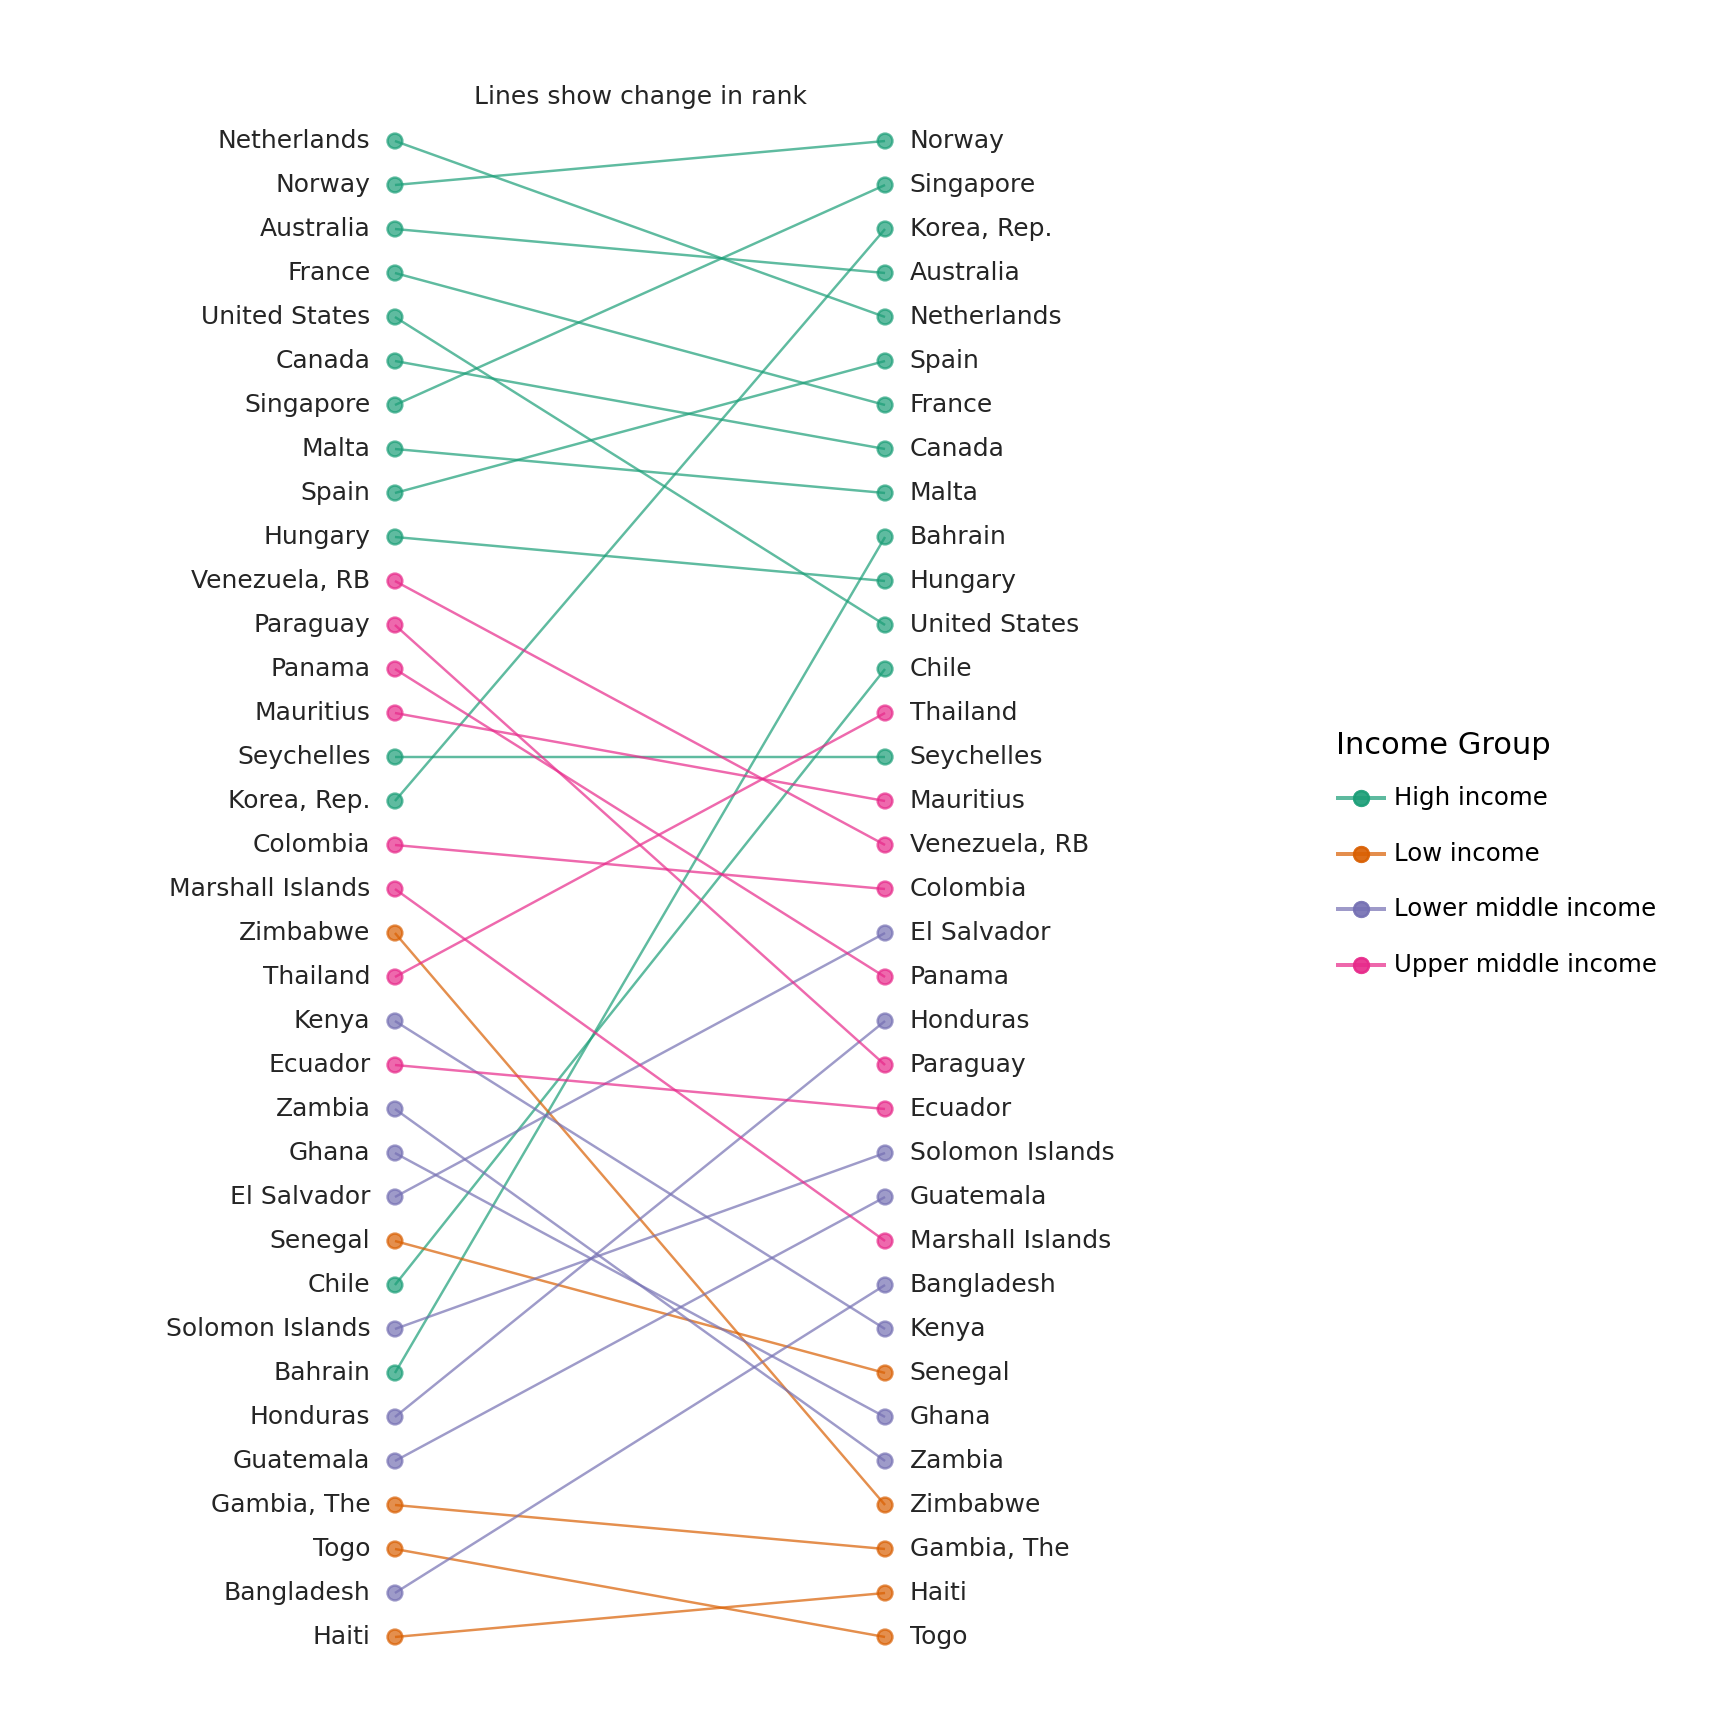

In [15]:
# Text colors
black1 = '#252525'
black2 = '#222222'

# Gallery Plot

(ggplot(sampled_data)
 # Slight modifications for the original lines,
 # 1. Nudge the text to either sides of the points
 # 2. Alter the color and alpha values
 + geom_text(aes(1, 'y1960_rank', label='country'), nudge_x=-0.05, ha='right', size=9, color=black1)
 + geom_text(aes(2, 'y2015_rank', label='country'), nudge_x=0.05, ha='left', size=9, color=black1)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_point(aes(2, 'y2015_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2015_rank', color='income_group'), alpha=.7)
 
 # Text Annotations
 #+ annotate('text', x=1, y=0, label='Rank in 1960', fontweight='bold', ha='right', size=10, color=black2)
 #+ annotate('text', x=2, y=0, label='Rank in 2015', fontweight='bold', ha='left', size=10, color=black2)
 + annotate('text', x=1.5, y=0, label='Lines show change in rank', size=9, color=black1)
 #+ annotate('label', x=1.5, y=3, label='Lower infant\ndeath rates', size=9, color=black1,
 #           label_size=0, fontstyle='italic')
 #+ annotate('label', x=1.5, y=33, label='Higher infant\ndeath rates', size=9, color=black1,
 #           label_size=0, fontstyle='italic')
 
 # Prevent country names from being chopped off
 + lims(x=(0.35, 2.65))
 + labs(color='Income Group')
 # Countries with lower rates on top
 + scale_y_reverse()
 # Change colors
 + scale_color_brewer(type='qual', palette=2)
 # Removes all decorations
 + theme_void()
 # Changing the figure size prevents the country names from squishing up
 + theme(figure_size=(8, 11))
)